# Closing heat (and salt, maybe) budgets in ACCESS-OM2

This notebook describes how to close heat budgets in ACCESS-OM2 using the MOM5 heat budget diagnostics package.

For understanding these budgets, there are a few resources available:
- Summary of the heat budget in ESM2M (MOM5 based): https://mom-ocean.github.io/assets/pdfs/ESM2M_heat_budget.pdf
- Chapter 2.6 of the MOM5 manual: https://mom-ocean.github.io/assets/pdfs/MOM5_manual.pdf

This notebook will not describe all the details of how the budgets work, as these are described in the above resources. Instead, we focus on the terms that are required to close the budgets.

Much of this analysis will be based around the 1/4-degree OMIP-2 experiment `025deg_jra55_iaf_omip2_cycle6` as this has monthly output of a lot of different budget variables (including the full heat budget). 

Note that the terms included in the budget depend on whether various parameterizations are active or not in the specific experiment you are interested in. For example, the 1/10th degree simulations do not include the GM or Redi diffusion mesoscale parameterizations. We will note these differences where possible.

## Description of the 3D Eulerian budget

The ACCESS-OM2/CM2 (i.e. MOM5) heat budget can be expressed as follows:

\begin{align}
  \textit{temp_tendency} = &\textit{temp_advection} + \\ &\quad +
  \textit{temp_submeso} \\ &\quad + \textit{temp_vdiffuse_diff_cbt}  + \textit{temp_nonlocal_KPP} \\ &\quad + \textit{sw_heat} +
  \textit{temp_rivermix} + \textit{temp_vdiffuse_sbc} + \textit{sfc_hflux_pme} \\
   & \quad + \textit{frazil_3d} \\ 
   & \quad + \textit{temp_vdiffuse_k33} + \textit{neutral_diffusion_temp} \\
   & \quad + \textit{neutral_gm_temp} \\
   & \quad + \textit{mixdownslope_temp} + \textit{temp_sigma_diff} + \textit{temp_eta_smooth}
\end{align}

All terms are in units of Wm$^{-2}$ corresponding to the heat content tendency per unit area within each grid cell. I.e. the temp_tendency term is given by:

\begin{equation}
\frac{\partial}{\partial t}\left(\rho_0 C_p\Theta \Delta z\right)
\end{equation}

where $\Delta z$ is the time variable grid cell thickness, $\rho_0=1035$kgm$^{-3}$ is the reference density, $C_p=3992.10322329649$Jkg$^{-1}$ $^\circ$C$^{-1}$ is the specific heat and $\Theta$ is Conservative Temperature ([McDougall 2003](https://doi.org/10.1175/1520-0485(2003)033%3C0945:PEACOV%3E2.0.CO;2), effectively a temperature variable constructed such that we can use a constant specific heat). It is important to note that this is a *heat* budget not a temperature budget, and thus the time variability of the vertical grid thicknesses must be taken into account.

The terms can be described as follows:

- temp_advection is the convergence of the three-dimensional resolved advection (this can be split into components by taking the convergence of the temp\_xflux\_adv, temp\_yflux\_adv and temp\_zflux\_adv terms, but note that one must be careful with the interpretation of these terms as they may or may not depend on the arbitrary reference temperature).
- temp_submeso is the convergence of the three-dimensional parameterized submesoscale advection (generally pretty small, [Fox-Kemper et al. 2009](https://doi.org/10.1175/2007JPO3792.1)).
- temp_vdiffuse_diff_cbt and temp_nonlocal_KPP are the vertical mixing terms. The first corresponds to the diffusive terms including [KPP](https://doi.org/10.1029/94RG01872) boundary layer diffusion, shear-driven interior diffusion, background diffusion (whose formulation differs depending on the configuration/resolution), double-diffusive mixing and bottom-intensified tidal mixing ([Simmons et al. 2004](https://doi.org/10.1016/S1463-5003(03)00011-8)). The second term is the non-local flux term within the KPP boundary layer scheme.
- temp_rivermix is a heat source associated with the mixing of riverwaters (this is 3D - the scheme mixes the riverwater across the top 4 grid cells).
- temp_vdiffuse_sbc captures non-volume-flux-related surface heat fluxes (e.g. latent, sensible, SW and LW). Note that this term does not account for SW penetration (see sw_heat). This is a 2D term.
- sw_heat accounts for the penetration of SW radiation into the ocean. It is a redistribution term - it sums to zero in the vertical, is large and negative in the surface layer (to compensate for the SW deposited in the surface layer by temp_vdiffuse_sfc) and positive below.
- sfc_hflux_pme captures volume-flux associated surface heat fluxes, including precipitation, evaporation and river run-off. These processes add heat to the ocean through the addition of volume (in MOM5 precipitation enters the surface ocean at the surface temperature).
- frazil_3d is the heat source due to the formation of frazil ice. This is 3-dimensional as frazil can be formed below the surface layer. Note that in later ACCESS-OM2 runs a new 2D diagnostic frazil_3d_int_z was added that corresponds to the vertical integral of frazil_3d (this is distinct from frazil_2d which only includes the surface layer!).
- temp_vdiffuse_k33 and neutral_diffusion_temp are parameterized along-isopycnal diffusion terms ([Redi 1982](https://doi.org/10.1175/1520-0485(1982)012%3C1154:OIMBCR%3E2.0.CO;2)). These terms are active at 1-degree and most 1/4-degree configurations, but not at 1/10-degree.
- neutral_gm_temp is parameterization advection by mesoscale eddies ([Gent and McWilliams 1990](https://doi.org/10.1175/1520-0485(1990)020%3C0150:IMIOCM%3E2.0.CO;2)). This term is active at 1-degree and most 1/4-degree configurations, but not at 1/10-degree. Note that the Gent and McWilliams scheme is implemented as skew-diffusion (see [Griffies 1998](https://doi.org/10.1175/1520-0485(1998)028<0831:TGMSF>2.0.CO;2)), not as an additional eddy-induced advection (this influences, in particular, the interpretation of its components, temp_xflux_gm, temp_yflux_gm, temp_zflux_gm).
- mixdownslope_temp and temp_sigma_diff are miscelleneuous mixing terms only active in the 1-degree version.
- temp_eta_smooth is the heat transport convergence associated with the SSH smoothing operator included to prevent numerical checkerboard instabilities on a B-grid (another small term). Active in all configurations.

## Surface heat flux components

See issue: https://github.com/COSIMA/access-om2/issues/139

The total heat flux into the ocean from surface forcing and ice-ocean exchanges is:

net_sfc_heating + frazil_3d_int_z

where,

net_sfc_heating = sfc_hflux_coupler + sfc_hflux_pme + sfc_hflux_from_runoff + sfc_hflux_from_calving

sfc_hflux_coupler = swflx + lw_heat + fprec_melt_heat + calving_melt_heat + sens_heat + evap_heat + mh_flux + liceht

Note the calving terms and liceht are currently zero in ACCESS-OM.

The vertical sum of the 3D Eulerian heat budget diagnostic temp_vdiffuse_sbc and frazil_3d will give the same result as net_sfc_heating + frazil_3d_int_z.

## The vertically-integrated heat budget

First, import some required modules and functions.

In [6]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client

You should also set up a `dask` client - this code uses the vanilla method for doing this. I suggest using Gadi and an entire node (48 cores) for this calculation.

In [2]:
## once you've set up a dask-worker, connect to it, click the dashboard link to check worker status
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43085/status,
Dashboard: /proxy/43085/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38397,Workers: 2
Dashboard: /proxy/43085/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:45951,Total threads: 1
Dashboard: /proxy/33811/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44675,


In [5]:
session = cc.database.create_session()
expt = '025deg_jra55_iaf_omip2_cycle6'

In [11]:
terms3D = ['temp_tendency','temp_advection','temp_submeso',
        'temp_vdiffuse_diff_cbt','temp_nonlocal_KPP','sw_heat','temp_vdiffuse_sbc',
        'temp_rivermix','frazil_3d']
terms3DGM = ['temp_vdiffuse_k33','neutral_diffusion_temp','neutral_gm_temp'] # Only active in 1 and most 1/4-degree
terms2D = ['sfc_hflux_pme','temp_eta_smooth']

terms = terms3D+terms3DGM+terms2D

# Load all variables for a single time:
budget = {}
for term in terms:
    budget[term] = cc.querying.getvar(expt, term, session, frequency='1 monthly', n=-1).isel(time=0)
for term in terms3D+terms3DGM:
    budget[term] = budget[term].sum('st_ocean')

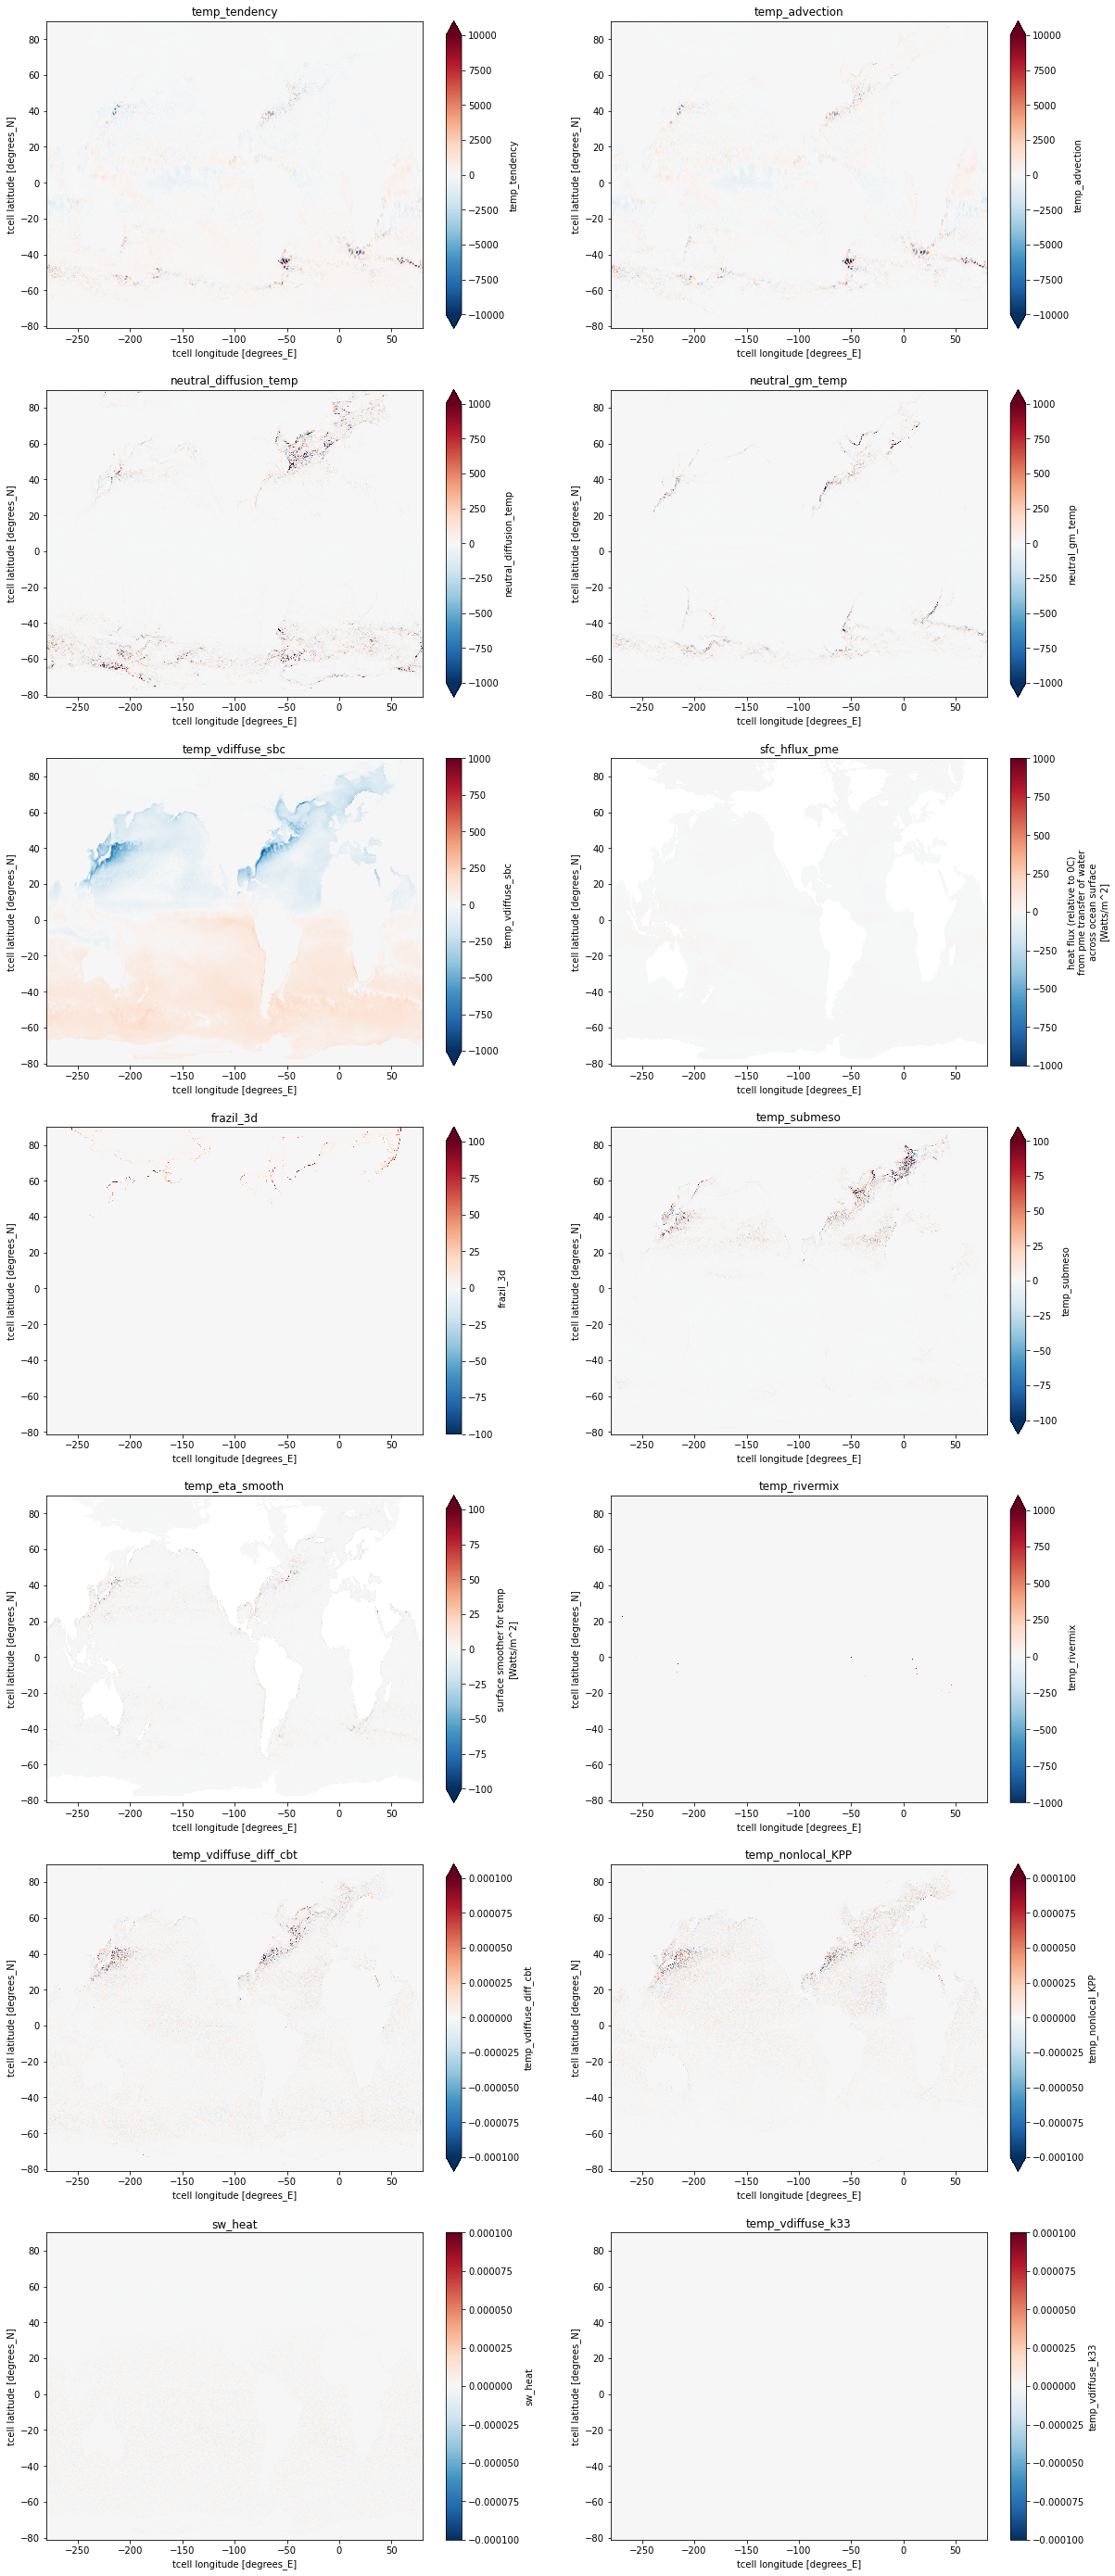

In [19]:
# Plot vertically integrated budget:
fig,axes = plt.subplots(nrows=7,ncols=2,figsize=(20,50))
axs = axes.reshape(-1)

lims = {'temp_tendency':[-1.e4,1.e4],
        'temp_advection':[-1.e4,1.e4],
        'neutral_diffusion_temp':[-1.e3,1.e3],
        'neutral_gm_temp':[-1.e3,1.e3],
        'temp_vdiffuse_sbc':[-1.e3,1.e3],
        'sfc_hflux_pme':[-1.e3,1.e3],
        'frazil_3d':[-1.e2,1.e2],
        'temp_submeso':[-1.e2,1.e2],
        'temp_eta_smooth':[-1.e2,1.e2],
        'temp_rivermix':[-1.e3,1.e3],
        'temp_vdiffuse_diff_cbt':[-1.e-4,1.e-4],
        'temp_nonlocal_KPP':[-1.e-4,1.e-4],
        'sw_heat':[-1.e-4,1.e-4],
        'temp_vdiffuse_k33':[-1.e-4,1.e-4]}

for i, term in enumerate(lims.keys()):
    budget[term].plot(ax=axs[i],cmap='RdBu_r',vmin=lims[term][0],vmax=lims[term][1])
    axs[i].set_title(term)    

## Other subjects that could/should be treated here:
- Numerical accuracy of the budget; issues with time-averaging, rounding errors etc.
- Dependence of the budget on the arbitrary reference temperature (e.g. Kelvin vs. Celsius), in particular interpretation of the components of advection given non-zero mass fluxes.
- Helmholtz decompositions of the vertically-integrated heat transport ([Forget and Ferreira 2019](https://doi.org/10.1038/s41561-019-0333-7)).
- Relating tendencies to the evolution of the time-averaged tracer content ('hat-averaging`, Bladwell et al. in prep.)
- Closing salt budgets